In [1]:
import numpy as np
import pandas as pd
from pydub import AudioSegment
import librosa
import os
import fleep
import librosa
import matplotlib.pyplot as plt
from bidi.algorithm import get_display
from arabic_reshaper import reshape

In [2]:
for dastgah in range(7):
    directory_path = "./Data"
    instrument_path = directory_path + os.sep + "D_" + str(dastgah) + os.sep + "I_1"
    for music in os.listdir(instrument_path):
        if music.endswith(".mp3"):
            music_name = music
            break
            
    sound = AudioSegment.from_file(instrument_path + os.sep + music_name)
    sound.export("./samples/D_" + str(dastgah) + ".wav")

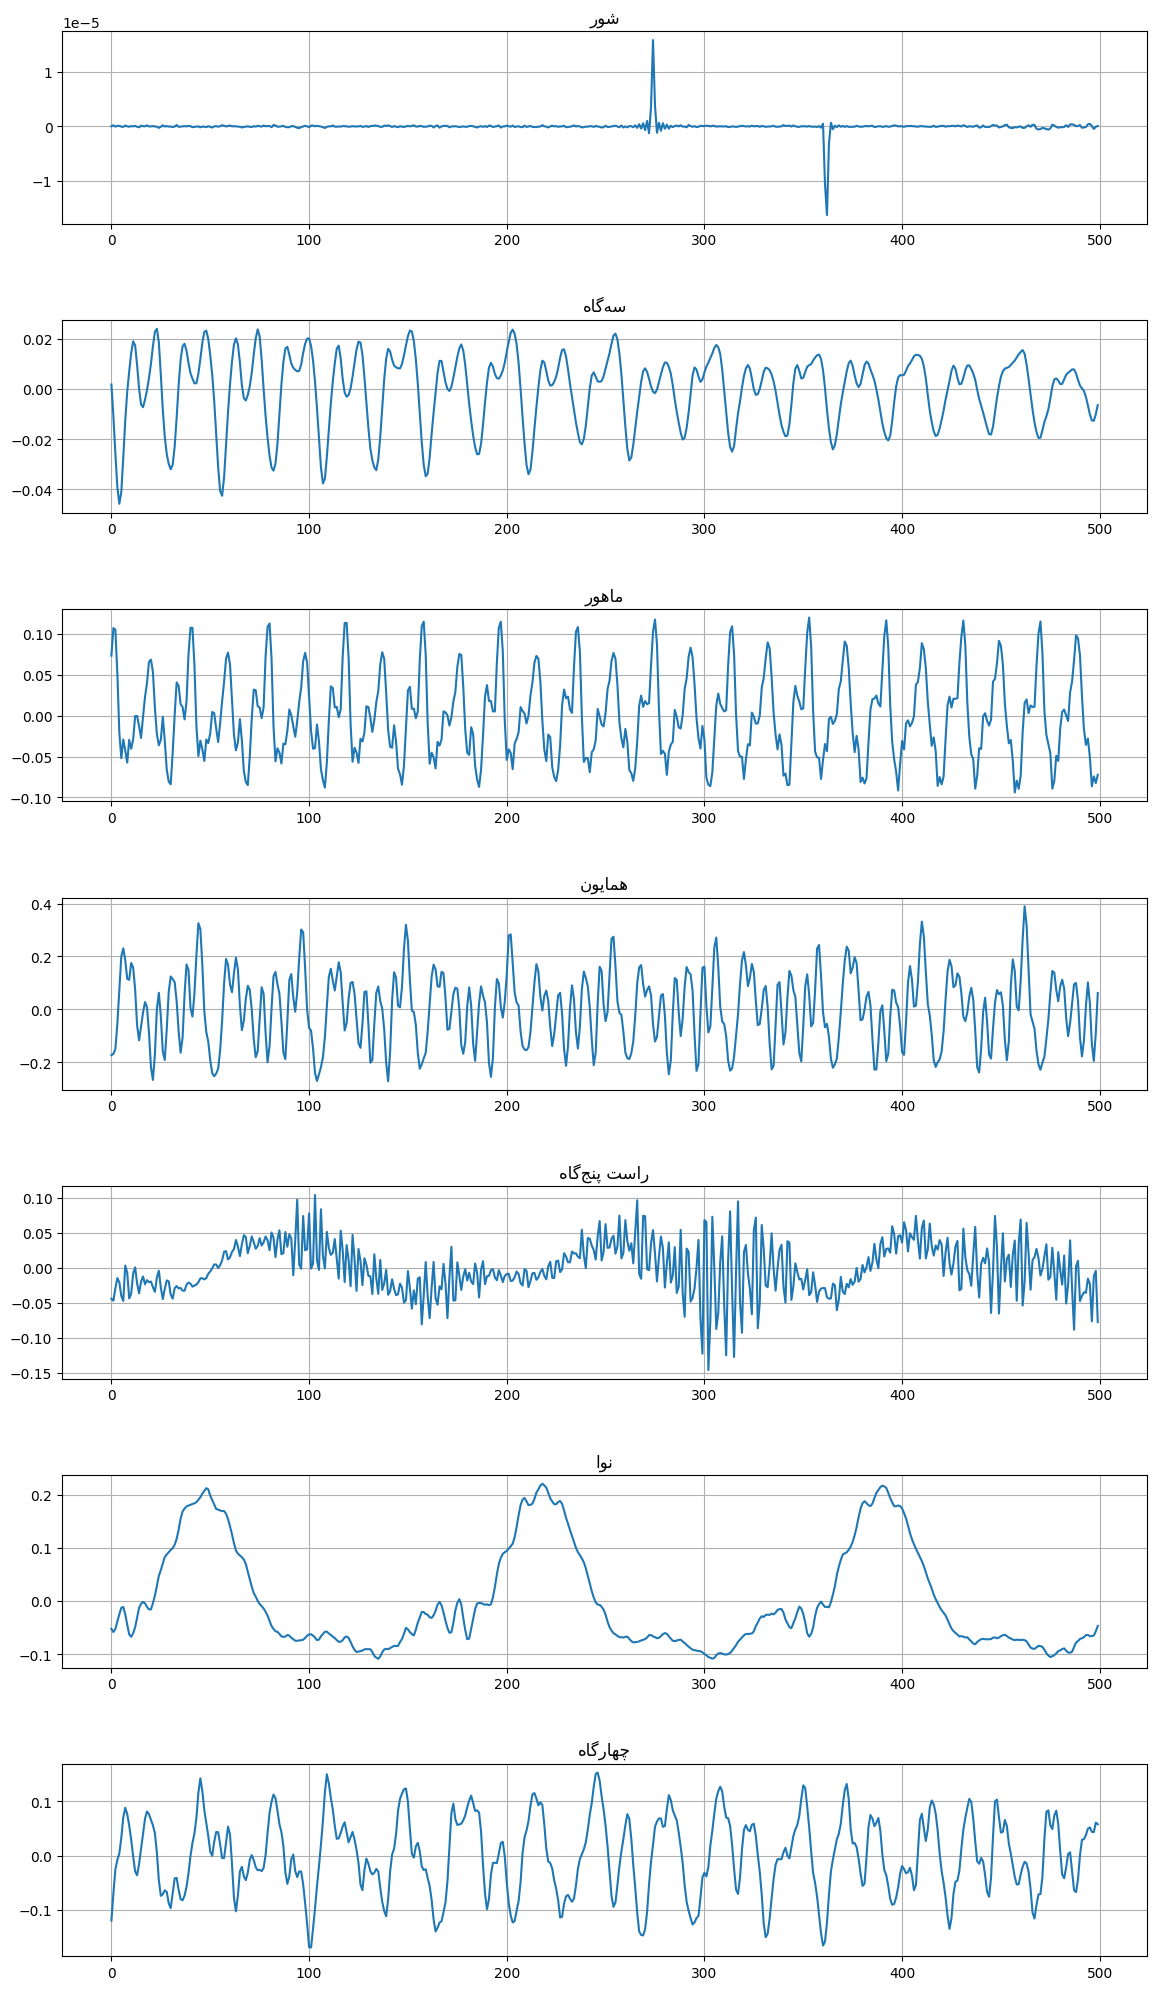

In [4]:
dastgah = {
    0: "شور",
    1: "سه‌گاه",
    2: "ماهور",
    3: "همایون",
    4: "راست پنج‌گاه",
    5: "نوا",
    6: "چهارگاه"
}

labels = dastgah.values()
persian_labels = [get_display(reshape(label)) for label in labels]

plt.figure(figsize=(14, 25))

for i in dastgah.keys():
    y, sr = librosa.load("./samples/D_" + str(i) + ".wav")
    
    plt.subplot(7, 1, i + 1)
    plt.subplots_adjust(hspace=0.5)
    plt.plot(y[15000:15500])
    plt.grid()
    plt.title(persian_labels[i])
    
plt.show()    

In [2]:
def split_audio(audio, part_length):
    audio_length = len(audio)
    part_count = audio_length // part_length
    extra = audio_length - part_count * part_length
    start = extra // 2
    for i in range(part_count):
        yield audio[start: start + part_length], i
        start += part_length

In [3]:
def convert_files(files_path, final_path, part_length):
    for file_name in os.listdir(files_path):
        file_path = files_path + os.sep + file_name
        with open(file_path, 'rb') as file:
            info = fleep.get(file.read(128))
        if len(info.extension) == 0:
            continue
        audio = AudioSegment.from_file(file_path, format=info.extension[0])
        for part, i in split_audio(audio, part_length):
            part_name = '.'.join(file_name.split('.')[:-1]) + '_' + str(i) + '.wav'
            part_path = final_path + os.sep + part_name
            part.export(part_path, format='wav')

In [4]:
def prepare_files(data_path, final_path, categories, part_length):
    os.makedirs(final_path, exist_ok=True)
    for i in range(len(categories)):
        category_path = data_path + os.sep + 'D_' + str(i)
        final_category_path = final_path + os.sep + categories[i]
        os.makedirs(final_category_path, exist_ok=True)
        for category_dir in os.listdir(category_path):
            instrument_path = category_path + os.sep + category_dir
            convert_files(instrument_path, final_category_path, part_length)

In [ ]:
categories = ['D_0', 'D_1', 'D_2', 'D_3', 'D_4', 'D_5', 'D_6']
prepare_files('./Data', './ConvertedData', categories, 30000)

In [ ]:
def extract_features(data, sample_rate):
    features = []
    # MFCC
    mfcc = librosa.feature.mfcc(y=data)
    features += mfcc.mean(axis=1).tolist()
    features += mfcc.var(axis=1).tolist()

    # Zero-Crossing rate
    zcr = librosa.feature.zero_crossing_rate(y=data)
    features.append(np.mean(zcr))

    # Spectral roll off
    spectral_rolloffs = librosa.feature.spectral_rolloff(y=data, sr=sample_rate)
    features.append(np.mean(spectral_rolloffs))
    features.append(np.var(spectral_rolloffs))

    # Chroma
    chroma = librosa.feature.chroma_stft(y=data, sr=sample_rate)
    features += chroma.mean(axis=1).tolist()
    features += chroma.var(axis=1).tolist()

    # Spectral Centroid
    spectral_centroids = librosa.feature.spectral_centroid(y=data, sr=sample_rate)
    features.append(spectral_centroids.mean())
    features.append(spectral_centroids.var())

    return features

In [10]:
def prepare_csv(data_path, final_path, categories):
    data_mat = []
    os.makedirs(final_path, exist_ok=True)
    for category in categories:
        category_path = data_path + os.sep + category
        for file_name in os.listdir(category_path):
            file_path = category_path + os.sep + file_name
            data, sample_rate = librosa.load(file_path)
            new_row = [category]
            new_row += extract_features(data, sample_rate)
            data_mat.append(new_row)
            
        csv_path = final_path + os.sep + category +'.csv'
        df = pd.DataFrame(data_mat)
        df.to_csv(csv_path)
        data_mat = []

In [ ]:
prepare_csv('./ConvertedData', './CSVFiles', ['D_0', 'D_1', 'D_2', 'D_3', 'D_4', 'D_5', 'D_6'])

In [7]:
csv_dir = './CSVFiles'
df = pd.DataFrame()
for csv_name in os.listdir(csv_dir):
    csv_path = csv_dir + os.sep + csv_name
    df = pd.concat([df, pd.read_csv(csv_path, index_col='Unnamed: 0')])
df.to_csv('data.csv', index=False)